# Data Preprocessing Steps

1. Running FFT analysis on SEEG data - log seizure times using Z
2. Running FFT projection into 2D tensors, or 3D tensors - log seizure times using preivous step
2D = [numsamps, numfreqs, W, H]
3D = [numsamps, numfreqs, W, H, D]

To project onto 2D or 3D, we will define a mesh grid of the image in brain MRI space. So the electrodes need to have defined xyz coordinates in the MRI (e.g. say freesurfer, or flirt space) when doing reconstructions.

Then each step will be saved with the corresponding data samples as a .npz file.

In [2]:
import sys
sys.path.append('../')
# from fragility.signalprocessing import frequencyanalysis
# from datainterface import readmat

# sys.path.append('/home/adamli/tng_tvb/')
# from tvbsim import visualize

import os
import time

import numpy as np
import pandas as pd
import scipy
import scipy.io


import processing.util as util
import processing.frequencytransform as ft
import peakdetect
import processing.preprocessfft as preprocess

# sys.path.append('/Users/adam2392/Documents/tvb/')
# sys.path.append('/Users/adam2392/Documents/tvb/_tvbdata/')
# sys.path.append('/Users/adam2392/Documents/tvb/_tvblibrary/')
# from tvb.simulator.lab import *
# import tvbsim.util

from natsort import natsorted
import ntpath
from scipy.signal import butter, lfilter

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def _gettimepoints(numsignals, numwinsamps, numstepsamps):
    # create array of indices of window start times
    timestarts = np.arange(0, numsignals-numwinsamps+1, numstepsamps)
    # create array of indices of window end times
    timeends = np.arange(numwinsamps-1, numsignals, numstepsamps)
    # create the timepoints array for entire data array
    timepoints = np.append(timestarts.reshape(len(timestarts), 1), timeends.reshape(len(timestarts), 1), axis=1)
    return timepoints

def getseiztimes(onsettimes, offsettimes):
    minsize = np.min((len(onsettimes),len(offsettimes)))
    seizonsets = []
    seizoffsets = []
    
    # perform some checks
    if minsize == 0:
        print("no full onset/offset available!")
        return 0
    
    idx = 0
    # to store the ones we are checking rn
    _onset = onsettimes[idx]
    _offset = offsettimes[idx]
    seizonsets.append(_onset)
    
    # start loop after the first onset/offset pair
    for i in range(1,minsize):        
        # to store the previoius values
        _nextonset = onsettimes[i]
        _nextoffset = offsettimes[i]
        
        # check this range and add the offset if it was a full seizure
        # before the next seizure
        if _nextonset < _offset:
            _offset = _nextoffset
        else:
            seizoffsets.append(_offset)
            idx = i
            # to store the ones we are checking rn
            _onset = onsettimes[idx]
            _offset = offsettimes[idx]
            seizonsets.append(_onset)
    if len(seizonsets) != len(seizoffsets):
        seizonsets = seizonsets[0:len(seizoffsets)]
    return seizonsets, seizoffsets
def findonsetoffset(zts, delta=0.2/8):
    maxpeaks, minpeaks = peakdetect.peakdetect(zts, delta=delta)

    # get every other peaks
    onsettime, _ = zip(*minpeaks)
    offsettime, _ = zip(*maxpeaks)

    return onsettime, offsettime
def getonsetsoffsets(zts, ezindices, pzindices, delta=0.2/8):
    # create lambda function for checking the indices
    check = lambda indices: isinstance(indices,np.ndarray) and len(indices)>=1

    onsettimes=np.array([])
    offsettimes=np.array([])
    if check(ezindices):
        for ezindex in ezindices:
            _onsettimes, _offsettimes = findonsetoffset(zts[ezindex, :].squeeze(), 
                                                                    delta=delta)
            onsettimes = np.append(onsettimes, np.asarray(_onsettimes))
            offsettimes = np.append(offsettimes, np.asarray(_offsettimes))

    if check(pzindices):
        for pzindex in pzindices:
            _onsettimes, _offsettimes = findonsetoffset(zts[pzindex, :].squeeze(), 
                                                                    delta=delta)
            onsettimes = np.append(onsettimes, np.asarray(_onsettimes))
            offsettimes = np.append(offsettimes, np.asarray(_offsettimes))

    # first sort onsettimes and offsettimes
    onsettimes.sort()
    offsettimes.sort()
    
    return onsettimes, offsettimes

In [13]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y
def butter_highpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='highpass', analog=False)
    return b, a
def butter_highpass_filter(data, lowcut, fs, order=5):
    b, a = butter_highpass(lowcut, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y

# 1. Run FFT Analysis on All SEEG Simulated Data

SEEG Simulated data is assumed to be bandpass filtered when simulations were generated.
Run a check on the onset/offset times.

First, create a dataset from the old files with bandpass filtering ran on them (although these seizures are not as "realistic"), so keep this dataset separate until we loop them into the training procedure. In essence, if there were any that was bandpassed, then this would just essentially be adding another order to the butterworth filter (another convolution/multiplication).

Then create another dataset that is more robust starting from moved_v2 that has bandpass filtering already applied, and then store that dataset and keep appending, as I generate more and more data (_v3, v4, etc....)

*Need to add the index to start from the largest in the list in the directory so far, else = 0*

In [51]:
datadir = '/Volumes/ADAM LI/pydata/tvbforwardsim/varydistance/'
metadatadir = '/Volumes/ADAM LI/pydata/metadata/'    
traindir = '/Volumes/ADAM LI/pydata/traindata/fft/'

# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(datadir):
    if 'allregions_sim' not in root:
        for file in files:
            if file.endswith(".npz"):
                 datafiles.append(os.path.join(root, file))
print(len(datafiles))
# print(datafiles[50:])

25


In [27]:
# establish frequency bands
freqbands = {
        'dalpha':[0,15],
        'beta':[15,30],
        'gamma':[30,90],
        'high':[90,200],
    }
postprocessfft = preprocess.PreProcess(freqbands=freqbands)

In [28]:
# FFT Parameters
fs = 1000
winsize = 1000 # winsize in milliseconds
stepsize = 500 # stepsize in milliseconds
typetransform = 'fourier'
mtbandwidth = 4
mtfreqs = []

mtaper = ft.MultiTaperFFT(winsize, stepsize, fs, mtbandwidth, mtfreqs)

Default method of tapering is eigen


In [52]:
for idx, datafile in enumerate(datafiles):
    filename = path_leaf(datafile)
    
    data = np.load(datafile, encoding='bytes')
    metadata = data['metadata'].item()
    zts = data['zts']
    seegts = data['seegts']
    
    # Extract location coordinates
    locations = metadata[b'seeg_xyz']
    try:
        patient_id = metadata[b'patient'].decode("utf-8") 
    except:
        patient = '_'.join(filename.split('_')[0:2])

    ezindices = metadata[b'ezindices']
    pzindices = metadata[b'pzindices']
    x0 = metadata[b'x0ez']
    seeg_contacts = metadata[b'seeg_contacts']

    # get onset/offset times correctly
    onsettimes, offsettimes = getonsetsoffsets(zts, np.array(ezindices).ravel(), np.array(pzindices).ravel())

    # get the actual seizure times and offsets
    seizonsets, seizoffsets = getseiztimes(onsettimes, offsettimes)
    seizonsets = np.asarray(seizonsets)
    seizoffsets = np.asarray(seizoffsets)
    seiztimes = np.concatenate((seizonsets[:,np.newaxis], seizoffsets[:,np.newaxis]), axis=1)
    
    # filter the data in case it was not done already
    lowcut = 0.1
    highcut = 499.
    fs = 1000.
    newseegts = butter_bandpass_filter(seegts, lowcut, highcut, fs, order=4)

    mtaper.loadrawdata(newseegts)
    power, freqs, timepoints, _ = mtaper.mtwelch()
    power = postprocessfft.binFrequencyValues(power, freqs)
    
    filename = os.path.join(traindir, 
                            patient_id + '_nez' + str(len(ezindices)) + '_npz' + str(len(pzindices)) + '_'+str(idx) +'_varydist.npz')
    
    np.savez_compressed(filename, 
                        power=power, 
                        timepoints=timepoints,
                        seiztimes=seiztimes,
                        locs=locations,
                        seeg_contacts=seeg_contacts,
                        x0ez=x0)
    print(datafile)
    print(power.shape)
    print(freqs.shape)
    print(timepoints.shape)
    print(locations.shape)
    print(seeg_contacts.shape)
    print('\n\n')

Loaded raw data in MultiTaperFFT!


/Users/adam2392/Documents/dnn-unsupervised/dnn/processing/preprocessfft.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
  power_binned[:,idx,:] = np.mean(power[:,indices[0]:indices[1]+1,:], axis=1) #[np.newaxis,:,:]


/Volumes/ADAM LI/pydata/tvbforwardsim/varydistance/nez1_npz1_dist7/id001_ac_sim_nez1_npz1.npz
(70, 4, 439)
(501,)
(439, 2)
(70, 3)
(70,)



Loaded raw data in MultiTaperFFT!
/Volumes/ADAM LI/pydata/tvbforwardsim/varydistance/nez1_npz1_dist7/id002_cj_sim_nez1_npz1.npz
(162, 4, 439)
(501,)
(439, 2)
(162, 3)
(162,)



Loaded raw data in MultiTaperFFT!
/Volumes/ADAM LI/pydata/tvbforwardsim/varydistance/nez1_npz1_dist7/id014_rb_sim_nez1_npz1.npz
(165, 4, 439)
(501,)
(439, 2)
(165, 3)
(165,)



Loaded raw data in MultiTaperFFT!
/Volumes/ADAM LI/pydata/tvbforwardsim/varydistance/nez1_npz1_dist1/id001_ac_sim_nez1_npz1.npz
(70, 4, 235)
(501,)
(235, 2)
(70, 3)
(70,)



Loaded raw data in MultiTaperFFT!
/Volumes/ADAM LI/pydata/tvbforwardsim/varydistance/nez1_npz1_dist1/id002_cj_sim_nez1_npz1.npz
(162, 4, 229)
(501,)
(229, 2)
(162, 3)
(162,)



Loaded raw data in MultiTaperFFT!
/Volumes/ADAM LI/pydata/tvbforwardsim/varydistance/nez1_npz1_dist1/id014_rb_sim_nez1_npz1.npz
(165, 4, 249)
(501,)
(249, 

# 2. Run Image Transformation in 2D onto a Mesh grid

In [66]:
'''
This code segment should only be ran once, to extract metadata for each patient, 
so it doesn't need to be done in the loop for FFT compression.

EXTRACTS LOCATION DATA FOR EACH PATIENT
'''

patients = []
# get all patients in the dataset
for datafile in datafiles:
    filename = path_leaf(datafile)
    patient = '_'.join(filename.split('_')[0:2])
    if patient not in patients:
        patients.append(patient)
print(patients)

patient_dict = {}

# get all metadata for each patient
for patient in patients:
    project_dir = os.path.join(metadatadir, patient)
    confile = os.path.join(project_dir, "connectivity.zip")

    # get the regions, and region_centers from connectivity
    reader = util.ZipReader(confile)
    region_centers = reader.read_array_from_file("centres", use_cols=(1, 2, 3))
    regions = reader.read_array_from_file("centres", dtype=np.str, use_cols=(0,))

['id001_ac', 'id002_cj', 'id014_rb']


In [71]:
datadir = '/Volumes/ADAM LI/pydata/traindata/fft/after_v2/'
metadatadir = '/Volumes/ADAM LI/pydata/metadata/'    

# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        if file.endswith(".npz"):
             datafiles.append(os.path.join(root, file))
# print(datafiles)
print(len(datafiles))

43


In [72]:
from sklearn.decomposition import PCA
# define the data handler 
datahandler = util.DataHandler()
pca = PCA(n_components=2)

AZIM=0
trainimagedir = '/Volumes/ADAM LI/pydata/traindata/image_2d/after_v2/'
metadir = '/Volumes/ADAM LI/pydata/traindata/image_2d/after_v2/meta/'
if not os.path.exists(trainimagedir):
    os.makedirs(trainimagedir)
if not os.path.exists(metadir):
    os.makedirs(metadir)
# loop through each data file and get grid
for idx,datafile in enumerate(datafiles):
    # load data
    data = np.load(datafile, encoding='bytes')
    power = data['power']
    print(power.shape)
    print(data.keys())
    
    # load xyz data for this particular dataset
    xyz_data = data['locs']
    seeg_contacts = data['seeg_contacts']
    x0ez = data['x0ez']
    seiztimes = data['seiztimes']
    
    # project xyz data
    if AZIM==1:
        print("using azim projection to grid image")
        new_locs = []
        for ichan in range(0,xyz_data.shape[0]):
            new_locs.append(datahandler.azim_proj(xyz_data[ichan,:]))
        new_locs = np.asarray(new_locs)
    if AZIM==0:
        print("using pca to grid image")
        new_locs = pca.fit_transform(xyz_data)
    
    ylabels = datahandler.computelabels(seiztimes, timepoints)
    
    # Tensor of size [samples, freqbands, W, H] containing generated images.
    image_tensor = datahandler.gen_images(new_locs, power, 
                                n_gridpoints=32, normalize=True, augment=True, 
                                pca=False, std_mult=0.1, edgeless=False)

    # set saving file paths for image and corresponding meta data
    filename = path_leaf(datafile)
    imagefilename = os.path.join(trainimagedir, filename)
    metafilename = os.path.join(metadir, filename)
    
    # instantiate metadata hash table
    metadata = dict()
    metadata['x0ez'] = x0ez
    metadata['seeg_contacts'] = seeg_contacts
    metadata['new_locs'] = new_locs
    metadata['ylabels'] = ylabels
    
    # save image and meta data
    np.save(imagefilename, image_tensor)
    np.savez_compressed(metafilename, metadata=metadata)
    
    print(new_locs.shape)
#     break

(70, 4, 359)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
(359, 70)
Interpolating 359/359nterpolating 77/359Interpolating 124/359Interpolating 175/359Interpolating 224/359Interpolating 271/359Interpolating 317/359(70, 2)
(70, 4, 359)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
(359, 70)
(70, 2)lating 359/359terpolating 2/359Interpolating 53/359Interpolating 105/359Interpolating 156/359Interpolating 205/359Interpolating 255/359Interpolating 305/359Interpolating 354/359
(70, 4, 359)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
(359, 70)
(70, 2)lating 359/359nterpolating 45/359Interpolating 95/359Interpolating 146/359Interpolating 198/359Interpolating 247/359Interpolating 297/359Interpolating 348/359
(70, 4, 359)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
(359, 70)
(70, 2)lating 359/359nterpol

Interpolating 439/439nterpolating 27/439Interpolating 92/439Interpolating 125/439Interpolating 158/439Interpolating 191/439Interpolating 224/439Interpolating 257/439Interpolating 291/439Interpolating 324/439Interpolating 357/439Interpolating 390/439Interpolating 422/439(162, 2)
(70, 4, 249)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
no seizure times in <computelabels>!
(249, 70)
(70, 2)lating 249/249nterpolating 16/249Interpolating 67/249Interpolating 118/249Interpolating 169/249Interpolating 220/249
(162, 4, 239)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
no seizure times in <computelabels>!
(239, 162)
Interpolating 239/239nterpolating 26/239Interpolating 55/239Interpolating 85/239Interpolating 118/239Interpolating 150/239Interpolating 182/239Interpolating 214/239(162, 2)
(162, 4, 439)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
(439, 

# 3. Process FFT Analysis into a 3D Mesh Grid

Here, I need to just redefine how to generate images with the data handler class. I need to reate a mesh grid on the 3D space now instead of just on the 2D space.

I will name this new function gen_images3d

In [75]:
datadir = '/Volumes/ADAM LI/pydata/traindata/fft/after_v2/'
metadatadir = '/Volumes/ADAM LI/pydata/metadata/'    

# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        if file.endswith(".npz"):
             datafiles.append(os.path.join(root, file))
# print(datafiles)
print(len(datafiles))

43


In [76]:
# define the data handler 
datahandler = util.DataHandler()

trainimagedir = '/Volumes/ADAM LI/pydata/traindata/image_3d/after_v2/'
metadir = '/Volumes/ADAM LI/pydata/traindata/image_3d/after_v2/meta/'
if not os.path.exists(trainimagedir):
    os.makedirs(trainimagedir)
if not os.path.exists(metadir):
    os.makedirs(metadir)
    
# loop through each data file and get grid
for idx,datafile in enumerate(datafiles):
    # load data
    data = np.load(datafile, encoding='bytes')
    power = data['power']
    print(power.shape)
    print(data.keys())
    
    # load xyz data for this particular dataset
    xyz_data = data['locs']
    seeg_contacts = data['seeg_contacts']
    x0ez = data['x0ez']
    seiztimes = data['seiztimes']

    ylabels = datahandler.computelabels(seiztimes, timepoints)
    
    # Tensor of size [samples, freqbands, W, H] containing generated images.
    image_tensor = datahandler.gen_images3d(xyz_data, power, 
                                n_gridpoints=32, normalize=True, augment=False, 
                                std_mult=0.1, edgeless=False)

    # set saving file paths for image and corresponding meta data
    filename = path_leaf(datafile)
    imagefilename = os.path.join(trainimagedir, filename)
    metafilename = os.path.join(metadir, filename)
    
    # instantiate metadata hash table
    metadata = dict()
    metadata['x0ez'] = x0ez
    metadata['seeg_contacts'] = seeg_contacts
    metadata['seeg_xyz'] = xyz_data
    metadata['ylabels'] = ylabels
    
    # save image and meta data
    np.save(imagefilename, image_tensor)
    np.savez_compressed(metafilename, metadata=metadata)

(70, 4, 359)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
(359, 70)
Interpolating 359/359nterpolating 23/359Interpolating 35/359Interpolating 48/359Interpolating 61/359Interpolating 74/359Interpolating 87/359Interpolating 100/359Interpolating 113/359Interpolating 126/359Interpolating 140/359Interpolating 154/359Interpolating 168/359Interpolating 182/359Interpolating 195/359Interpolating 209/359Interpolating 223/359Interpolating 236/359Interpolating 250/359Interpolating 263/359Interpolating 276/359Interpolating 289/359Interpolating 303/359Interpolating 317/359Interpolating 331/359Interpolating 344/359Interpolating 357/359(70, 4, 359)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
(359, 70)
Interpolating 359/359terpolating 8/359Interpolating 20/359Interpolating 33/359Interpolating 46/359Interpolating 59/359Interpolating 71/359Interpolating 84/359Interpolating 96/359Interpolating 109/359Interpolating 121/359Interpolating 133/359Interpolating

Interpolating 359/359terpolating 6/359Interpolating 15/359Interpolating 24/359Interpolating 33/359Interpolating 42/359Interpolating 51/359Interpolating 60/359Interpolating 69/359Interpolating 87/359Interpolating 96/359Interpolating 105/359Interpolating 114/359Interpolating 123/359Interpolating 132/359Interpolating 141/359Interpolating 150/359Interpolating 159/359Interpolating 168/359Interpolating 177/359Interpolating 186/359Interpolating 195/359Interpolating 204/359Interpolating 213/359Interpolating 222/359Interpolating 231/359Interpolating 240/359Interpolating 248/359Interpolating 257/359Interpolating 266/359Interpolating 275/359Interpolating 284/359Interpolating 293/359Interpolating 302/359Interpolating 310/359Interpolating 319/359Interpolating 328/359Interpolating 337/359Interpolating 346/359Interpolating 355/359(162, 4, 359)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
(359, 162)
Interpolating 359/359terpolating 6/359Interpolating 15/359Interpolating 24/359

Interpolating 439/439terpolating 9/439Interpolating 22/439Interpolating 34/439Interpolating 58/439Interpolating 71/439Interpolating 84/439Interpolating 97/439Interpolating 110/439Interpolating 123/439Interpolating 135/439Interpolating 147/439Interpolating 160/439Interpolating 172/439Interpolating 185/439Interpolating 197/439Interpolating 210/439Interpolating 222/439Interpolating 235/439Interpolating 248/439Interpolating 260/439Interpolating 273/439Interpolating 285/439Interpolating 298/439Interpolating 311/439Interpolating 323/439Interpolating 335/439Interpolating 347/439Interpolating 360/439Interpolating 372/439Interpolating 384/439Interpolating 397/439Interpolating 410/439Interpolating 423/439Interpolating 435/439(70, 4, 265)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
no seizure times in <computelabels>!
(265, 70)
Interpolating 265/265terpolating 9/265Interpolating 22/265Interpolating 34/265Interpolating 48/265Interpolating 62/265Interpolating 75/265Interpo

Interpolating 438/439terpolating 5/439Interpolating 13/439Interpolating 21/439Interpolating 29/439Interpolating 37/439Interpolating 45/439Interpolating 53/439Interpolating 60/439Interpolating 67/439Interpolating 74/439Interpolating 82/439Interpolating 90/439Interpolating 98/439Interpolating 106/439Interpolating 114/439Interpolating 122/439Interpolating 130/439Interpolating 138/439Interpolating 146/439Interpolating 154/439Interpolating 162/439Interpolating 170/439Interpolating 178/439Interpolating 186/439Interpolating 193/439Interpolating 201/439Interpolating 209/439Interpolating 217/439Interpolating 225/439Interpolating 233/439Interpolating 240/439Interpolating 248/439Interpolating 256/439Interpolating 264/439Interpolating 272/439Interpolating 280/439Interpolating 288/439Interpolating 296/439Interpolating 304/439Interpolating 312/439Interpolating 320/439Interpolating 328/439Interpolating 336/439Interpolating 344/439Interpolating 352/439Interpolating 359/439Interpolating 367/439Interpol

Interpolating 249/249terpolating 6/249Interpolating 14/249Interpolating 22/249Interpolating 38/249Interpolating 46/249Interpolating 54/249Interpolating 62/249Interpolating 70/249Interpolating 78/249Interpolating 86/249Interpolating 94/249Interpolating 102/249Interpolating 110/249Interpolating 118/249Interpolating 126/249Interpolating 134/249Interpolating 142/249Interpolating 150/249Interpolating 158/249Interpolating 166/249Interpolating 174/249Interpolating 182/249Interpolating 190/249Interpolating 198/249Interpolating 206/249Interpolating 214/249Interpolating 222/249Interpolating 230/249Interpolating 238/249Interpolating 246/249(165, 4, 439)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
(439, 165)
Interpolating 439/439terpolating 5/439Interpolating 12/439Interpolating 20/439Interpolating 28/439Interpolating 35/439Interpolating 42/439Interpolating 50/439Interpolating 58/439Interpolating 66/439Interpolating 73/439Interpolating 80/439Interpolating 87/439Interpolat

In [58]:
import matplotlib
import matplotlib.pyplot as plt

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    
    # initialize figure to draw on
    fig, ax = plt.subplots()
    ax.volume = volume
    
    # set index as the first axis
    ax.index = volume.shape[2] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j': # go to previous slice
        previous_slice(ax)
    elif event.key == 'k': # go to next slice
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    
def remove_keymap_conflicts(new_keys_set):
    '''
    a helper function to remove keys that we want 
    to use wherever they may appear in this dictionary.
    '''
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
    

<IPython.core.display.Javascript object>


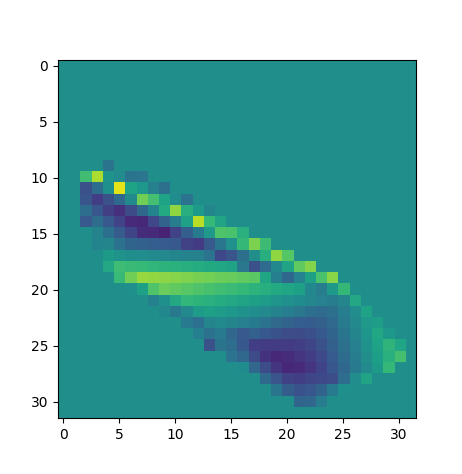

In [59]:
# fig, ax = plt.subplots()
# ax.imshow(image_tensor[0,0,:,:,:])
# fig.canvas.mpl_connect('key_press_event', process_key)
%matplotlib notebook
multi_slice_viewer(image_tensor[0,0,:,:,:])

# 4. Create YLabels Corresponding To The Image Dataset

Handle creating from scratch and if appending onto the image dataset with new images.

In [ ]:
trainimagedir = './traindata/images/'
metadir = './traindata/meta/'
if not os.path.exists(trainimagedir):
    os.makedirs(trainimagedir)
if not os.path.exists(metadir):
    os.makedirs(metadir)
trainlabeldir = './traindata/labels/'
if not os.path.exists(trainlabeldir):
    os.makedirs(trainlabeldir)

images = []
# loop through each data file and get grid
for idx,datafile in enumerate(datafiles):
    filename = path_leaf(datafile) + '.npy'
    metafile = path_leaf(datafile)
    imagefile = os.path.join(trainimagedir, filename)
    metafile = os.path.join(metadir, metafile)
    labelsfile = os.path.join(trainlabeldir, filename)
    
    metadata = np.load(metafile)
    metadata = metadata['metadata'].item()
#     print(metadata.keys())
    image = np.load(imagefile)
    label = np.load(labelsfile)
    
    if idx == 0:
        images = image
        ylabels = label
    else:
        images = np.concatenate((images, image), axis=0)
        ylabels = np.concatenate((ylabels, label), axis=0)
        
#     print(imagefile)
#     print(labelsfile)
#     print(image.shape)
#     print(label.shape)
    
#     break
print(images.shape)
print(ylabels.shape)